In [66]:

from music21 import converter, chord, note


In [69]:
dataset_name = 'cello'
filename = 'cs1-2all'
file = "D:/program/python/Lib/mylib/lstm/dataset/{}/{}.mid".format(dataset_name, filename)

original_score = converter.parse(file).chordify()

In [70]:
original_score.show('text')

{0.0} <music21.metadata.Metadata object at 0x2205db17580>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=250.0>
    {0.0} <music21.key.Key of G major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest 3.75ql>
    {3.5} <music21.tempo.MetronomeMark Quarter=77.0>
    {3.75} <music21.chord.Chord B3>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord G2 D3 B3>
    {1.0} <music21.chord.Chord B3>
    {1.25} <music21.chord.Chord A3>
    {1.5} <music21.chord.Chord G3>
    {1.75} <music21.chord.Chord F#3>
    {2.0} <music21.chord.Chord G3>
    {2.25} <music21.chord.Chord D3>
    {2.5} <music21.chord.Chord E3>
    {2.75} <music21.chord.Chord F#3>
    {3.0} <music21.chord.Chord G3>
    {3.25} <music21.chord.Chord A3>
    {3.5} <music21.chord.Chord B3>

In [71]:
notes = []
durations = []

for element in original_score.flat:
    
    if isinstance(element, chord.Chord):
        notes.append('.'.join(n.nameWithOctave for n in element.pitches))
        durations.append(element.duration.quarterLength)

    if isinstance(element, note.Note):
        if element.isRest:
            notes.append(str(element.name))
            durations.append(element.duration.quarterLength)
        else:
            notes.append(str(element.nameWithOctave))
            durations.append(element.duration.quarterLength)

    

In [72]:
print('\nduration', 'pitch')
for n,d in zip(notes,durations):
    print(d, '\t', n)


duration pitch
0.25 	 B3
1.0 	 G2.D3.B3
0.25 	 B3
0.25 	 A3
0.25 	 G3
0.25 	 F#3
0.25 	 G3
0.25 	 D3
0.25 	 E3
0.25 	 F#3
0.25 	 G3
0.25 	 A3
0.25 	 B3
0.25 	 C4
0.25 	 D4
0.25 	 B3
0.25 	 G3
0.25 	 F#3
0.25 	 G3
0.25 	 E3
0.25 	 D3
0.25 	 C3
0.25 	 B2
0.25 	 C3
0.25 	 D3
0.25 	 E3
0.25 	 F#3
0.25 	 G3
0.25 	 A3
0.25 	 B3
0.25 	 C4
0.25 	 A3
0.25 	 G3
0.25 	 F#3
0.25 	 G3
0.25 	 E3
0.25 	 F#3
0.25 	 G3
0.25 	 A2
0.25 	 D3
0.25 	 F#3
0.25 	 G3
0.25 	 A3
0.25 	 B3
0.25 	 C4
0.25 	 A3
0.25 	 B3
0.25 	 G3
0.25 	 G3
0.25 	 D3
0.25 	 D3
0.25 	 B2
0.25 	 B2
0.25 	 G2
0.75 	 G2
0.25 	 B3
0.25 	 C4
0.25 	 B3
0.25 	 A3
0.25 	 G3
0.25 	 A3
0.25 	 B3
0.25 	 C4
0.25 	 A3
0.25 	 G3
0.25 	 F#3
0.25 	 G3
0.25 	 A3
0.75 	 E-3
0.25 	 C4
0.25 	 B3
0.25 	 A3
0.25 	 G3
0.25 	 F#3
0.25 	 G3
0.25 	 E3
0.25 	 E3
0.25 	 B2
0.25 	 B2
0.25 	 G2
0.25 	 G2
0.25 	 E2
0.75 	 E2
0.25 	 B2
0.25 	 E3
0.25 	 G3
0.25 	 F#3
0.25 	 A3
0.25 	 G3
0.25 	 F#3
0.25 	 E3
0.25 	 F#3
0.25 	 G3
0.25 	 C#4
0.25 	 G3
0.25 	 F#3
0.25

In [73]:
import os
import pickle
import numpy
from music21 import note, chord

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

from RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network

In [75]:
# run params
section = 'compose'
run_id = '0006'
music_name = 'cello'

run_folder = 'run/{}/'.format(section)
run_folder += '_'.join([run_id, music_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('dataset', music_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'build' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True

In [76]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f) 
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 

36 files in total
1 Parsing dataset\cello\cs1-1pre.mid
2 Parsing dataset\cello\cs1-2all.mid
3 Parsing dataset\cello\cs1-3cou.mid
4 Parsing dataset\cello\cs1-4sar.mid
5 Parsing dataset\cello\cs1-5men.mid
6 Parsing dataset\cello\cs1-6gig.mid
7 Parsing dataset\cello\cs2-1pre.mid
8 Parsing dataset\cello\cs2-2all.mid
9 Parsing dataset\cello\cs2-3cou.mid
10 Parsing dataset\cello\cs2-4sar.mid
11 Parsing dataset\cello\cs2-5men.mid
12 Parsing dataset\cello\cs2-6gig.mid
13 Parsing dataset\cello\cs3-1pre.mid
14 Parsing dataset\cello\cs3-2all.mid
15 Parsing dataset\cello\cs3-3cou.mid
16 Parsing dataset\cello\cs3-4sar.mid
17 Parsing dataset\cello\cs3-5bou.mid
18 Parsing dataset\cello\cs3-6gig.mid
19 Parsing dataset\cello\cs4-1pre.mid
20 Parsing dataset\cello\cs4-2all.mid
21 Parsing dataset\cello\cs4-3cou.mid
22 Parsing dataset\cello\cs4-4sar.mid
23 Parsing dataset\cello\cs4-5bou.mid
24 Parsing dataset\cello\cs4-6gig.mid
25 Parsing dataset\cello\cs5-1pre.mid
26 Parsing dataset\cello\cs5-2all.mid
27 

In [77]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [78]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A2': 0,
 'A2.A3': 1,
 'A2.B-3': 2,
 'A2.B2': 3,
 'A2.C3': 4,
 'A2.D3': 5,
 'A2.E-3': 6,
 'A2.E3': 7,
 'A2.E3.A3': 8,
 'A2.E3.C#4': 9,
 'A2.E3.C#4.A4': 10,
 'A2.E3.C#4.E4': 11,
 'A2.E3.C#4.G#4': 12,
 'A2.E3.C4': 13,
 'A2.E3.D4': 14,
 'A2.F#3': 15,
 'A2.F#3.C4': 16,
 'A2.F#3.D4': 17,
 'A2.F#3.D4.A4': 18,
 'A2.F#3.D4.E4': 19,
 'A2.F#3.D4.F#4': 20,
 'A2.F#4': 21,
 'A2.F3': 22,
 'A2.F3.C4': 23,
 'A2.F3.D4': 24,
 'A2.F3.D4.A4': 25,
 'A2.G3': 26,
 'A2.G3.C#4': 27,
 'A2.G3.D4': 28,
 'A3': 29,
 'A3.B-3': 30,
 'A3.B3': 31,
 'A3.B3.C#4': 32,
 'A3.B3.C#4.D4': 33,
 'A3.B3.C4': 34,
 'A3.C#4': 35,
 'A3.C#4.E4': 36,
 'A3.C4': 37,
 'A3.D4': 38,
 'A3.E4': 39,
 'A3.E4.F#4': 40,
 'A3.E4.G4': 41,
 'A3.F#4': 42,
 'A3.F#4.G4': 43,
 'A3.F4': 44,
 'A3.G4': 45,
 'A4': 46,
 'A4.B4': 47,
 'B-2': 48,
 'B-2.A3': 49,
 'B-2.B-3': 50,
 'B-2.C3': 51,
 'B-2.D3': 52,
 'B-2.D3.A3': 53,
 'B-2.D3.E-3.G#3': 54,
 'B-2.D3.G#3': 55,
 'B-2.E-3': 56,
 'B-2.E3': 57,
 'B-2.E3.D4': 58,
 'B-2.F#3.C#4.E4': 59,
 'B-2.F3': 60,
 'B-2.F

In [79]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 0.5: 5,
 Fraction(2, 3): 6,
 0.75: 7,
 1.0: 8,
 1.25: 9,
 Fraction(4, 3): 10,
 1.5: 11,
 1.75: 12,
 2.0: 13,
 2.5: 14,
 3.0: 15,
 4.0: 16}

In [80]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [81]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[469 469 469 469 469 469 469 469 469 469 469 469 469 469 469 469 469 469
 469 469 469 469 469 469 469 469 469 469 469 469 469 469]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [82]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    47000       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    1700        ['input_2[0][0]']                
                                                                                              

d:\program\conda\envs\nmt_service\lib\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [83]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [84]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [85]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
model.fit(network_input, network_output
          , epochs=5000, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )



Epoch 1/5000
714/714 [==============================] - 108s 146ms/step - loss: 4.1011 - pitch_loss: 3.3507 - duration_loss: 0.7504 - val_loss: 6.2455 - val_pitch_loss: 5.3958 - val_duration_loss: 0.8496
Epoch 2/5000
714/714 [==============================] - 107s 150ms/step - loss: 3.6831 - pitch_loss: 3.1110 - duration_loss: 0.5721 - val_loss: 5.8646 - val_pitch_loss: 4.9903 - val_duration_loss: 0.8743
Epoch 3/5000
714/714 [==============================] - 109s 153ms/step - loss: 3.4736 - pitch_loss: 2.9677 - duration_loss: 0.5059 - val_loss: 5.8489 - val_pitch_loss: 5.0552 - val_duration_loss: 0.7938
Epoch 4/5000
714/714 [==============================] - 109s 153ms/step - loss: 3.2967 - pitch_loss: 2.8404 - duration_loss: 0.4564 - val_loss: 5.8230 - val_pitch_loss: 5.0981 - val_duration_loss: 0.7249
Epoch 5/5000
714/714 [==============================] - 113s 158ms/step - loss: 3.1499 - pitch_loss: 2.7326 - duration_loss: 0.4173 - val_loss: 6.0239 - val_pitch_loss: 5.2072 - val_du

In [86]:
import pickle as pkl
import time
import os
import numpy as np
import sys
from music21 import instrument, note, stream, chord, duration
from RNNAttention import create_network, sample_with_temp

import matplotlib.pyplot as plt

In [87]:
# run params
section = 'compose'
run_id = '0006'
music_name = 'cello'
run_folder = 'run/{}/'.format(section)
run_folder += '_'.join([run_id, music_name])

# model params
embed_size = 100
rnn_units = 256
use_attention = True

In [88]:

store_folder = os.path.join(run_folder, 'store')

with open(os.path.join(store_folder, 'distincts'), 'rb') as filepath:
    distincts = pkl.load(filepath)
    note_names, n_notes, duration_names, n_durations = distincts

with open(os.path.join(store_folder, 'lookups'), 'rb') as filepath:
    lookups = pkl.load(filepath)
    note_to_int, int_to_note, duration_to_int, int_to_duration = lookups

In [106]:
weights_folder = os.path.join(run_folder, 'weights')
weights_file = 'weights-improvement-131-0.1533-bigger.h5'

model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)

# Load the weights to each node
weight_source = os.path.join(weights_folder,weights_file)
model.load_weights(weight_source)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, None, 100)    47000       ['input_7[0][0]']                
                                                                                                  
 embedding_7 (Embedding)        (None, None, 100)    1700        ['input_8[0][0]']                
                                                                                            

In [107]:
# prediction params
notes_temp=0.5
duration_temp = 0.5
max_extra_notes = 50
max_seq_len = 32
seq_len = 32

# notes = ['START', 'D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3']
# durations = [0, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2]


# notes = ['START', 'F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3','F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3']
# durations = [0, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2]


notes = ['START']
durations = [0]

if seq_len is not None:
    notes = ['START'] * (seq_len - len(notes)) + notes
    durations = [0] * (seq_len - len(durations)) + durations


sequence_length = len(notes)

In [108]:
prediction_output = []
notes_input_sequence = []
durations_input_sequence = []

overall_preds = []

for n, d in zip(notes,durations):
    note_int = note_to_int[n]
    duration_int = duration_to_int[d]
    
    notes_input_sequence.append(note_int)
    durations_input_sequence.append(duration_int)
    
    prediction_output.append([n, d])
    
    if n != 'START':
        midi_note = note.Note(n)

        new_note = np.zeros(128)
        new_note[midi_note.pitch.midi] = 1
        overall_preds.append(new_note)


att_matrix = np.zeros(shape = (max_extra_notes+sequence_length, max_extra_notes))

for note_index in range(max_extra_notes):

    prediction_input = [
        np.array([notes_input_sequence])
        , np.array([durations_input_sequence])
       ]

    notes_prediction, durations_prediction = model.predict(prediction_input, verbose=0)
    if use_attention:
        att_prediction = att_model.predict(prediction_input, verbose=0)[0]
        att_matrix[(note_index-len(att_prediction)+sequence_length):(note_index+sequence_length), note_index] = att_prediction
    
    new_note = np.zeros(128)
    
    for idx, n_i in enumerate(notes_prediction[0]):
        try:
            note_name = int_to_note[idx]
            midi_note = note.Note(note_name)
            new_note[midi_note.pitch.midi] = n_i
            
        except:
            pass
        
    overall_preds.append(new_note)
            
    
    i1 = sample_with_temp(notes_prediction[0], notes_temp)
    i2 = sample_with_temp(durations_prediction[0], duration_temp)
    

    note_result = int_to_note[i1]
    duration_result = int_to_duration[i2]
    
    prediction_output.append([note_result, duration_result])

    notes_input_sequence.append(i1)
    durations_input_sequence.append(i2)
    
    if len(notes_input_sequence) > max_seq_len:
        notes_input_sequence = notes_input_sequence[1:]
        durations_input_sequence = durations_input_sequence[1:]
        
#     print(note_result)
#     print(duration_result)
        
    if note_result == 'START':
        break

overall_preds = np.transpose(np.array(overall_preds)) 
print('Generated sequence of {} notes'.format(len(prediction_output)))

Generated sequence of 82 notes


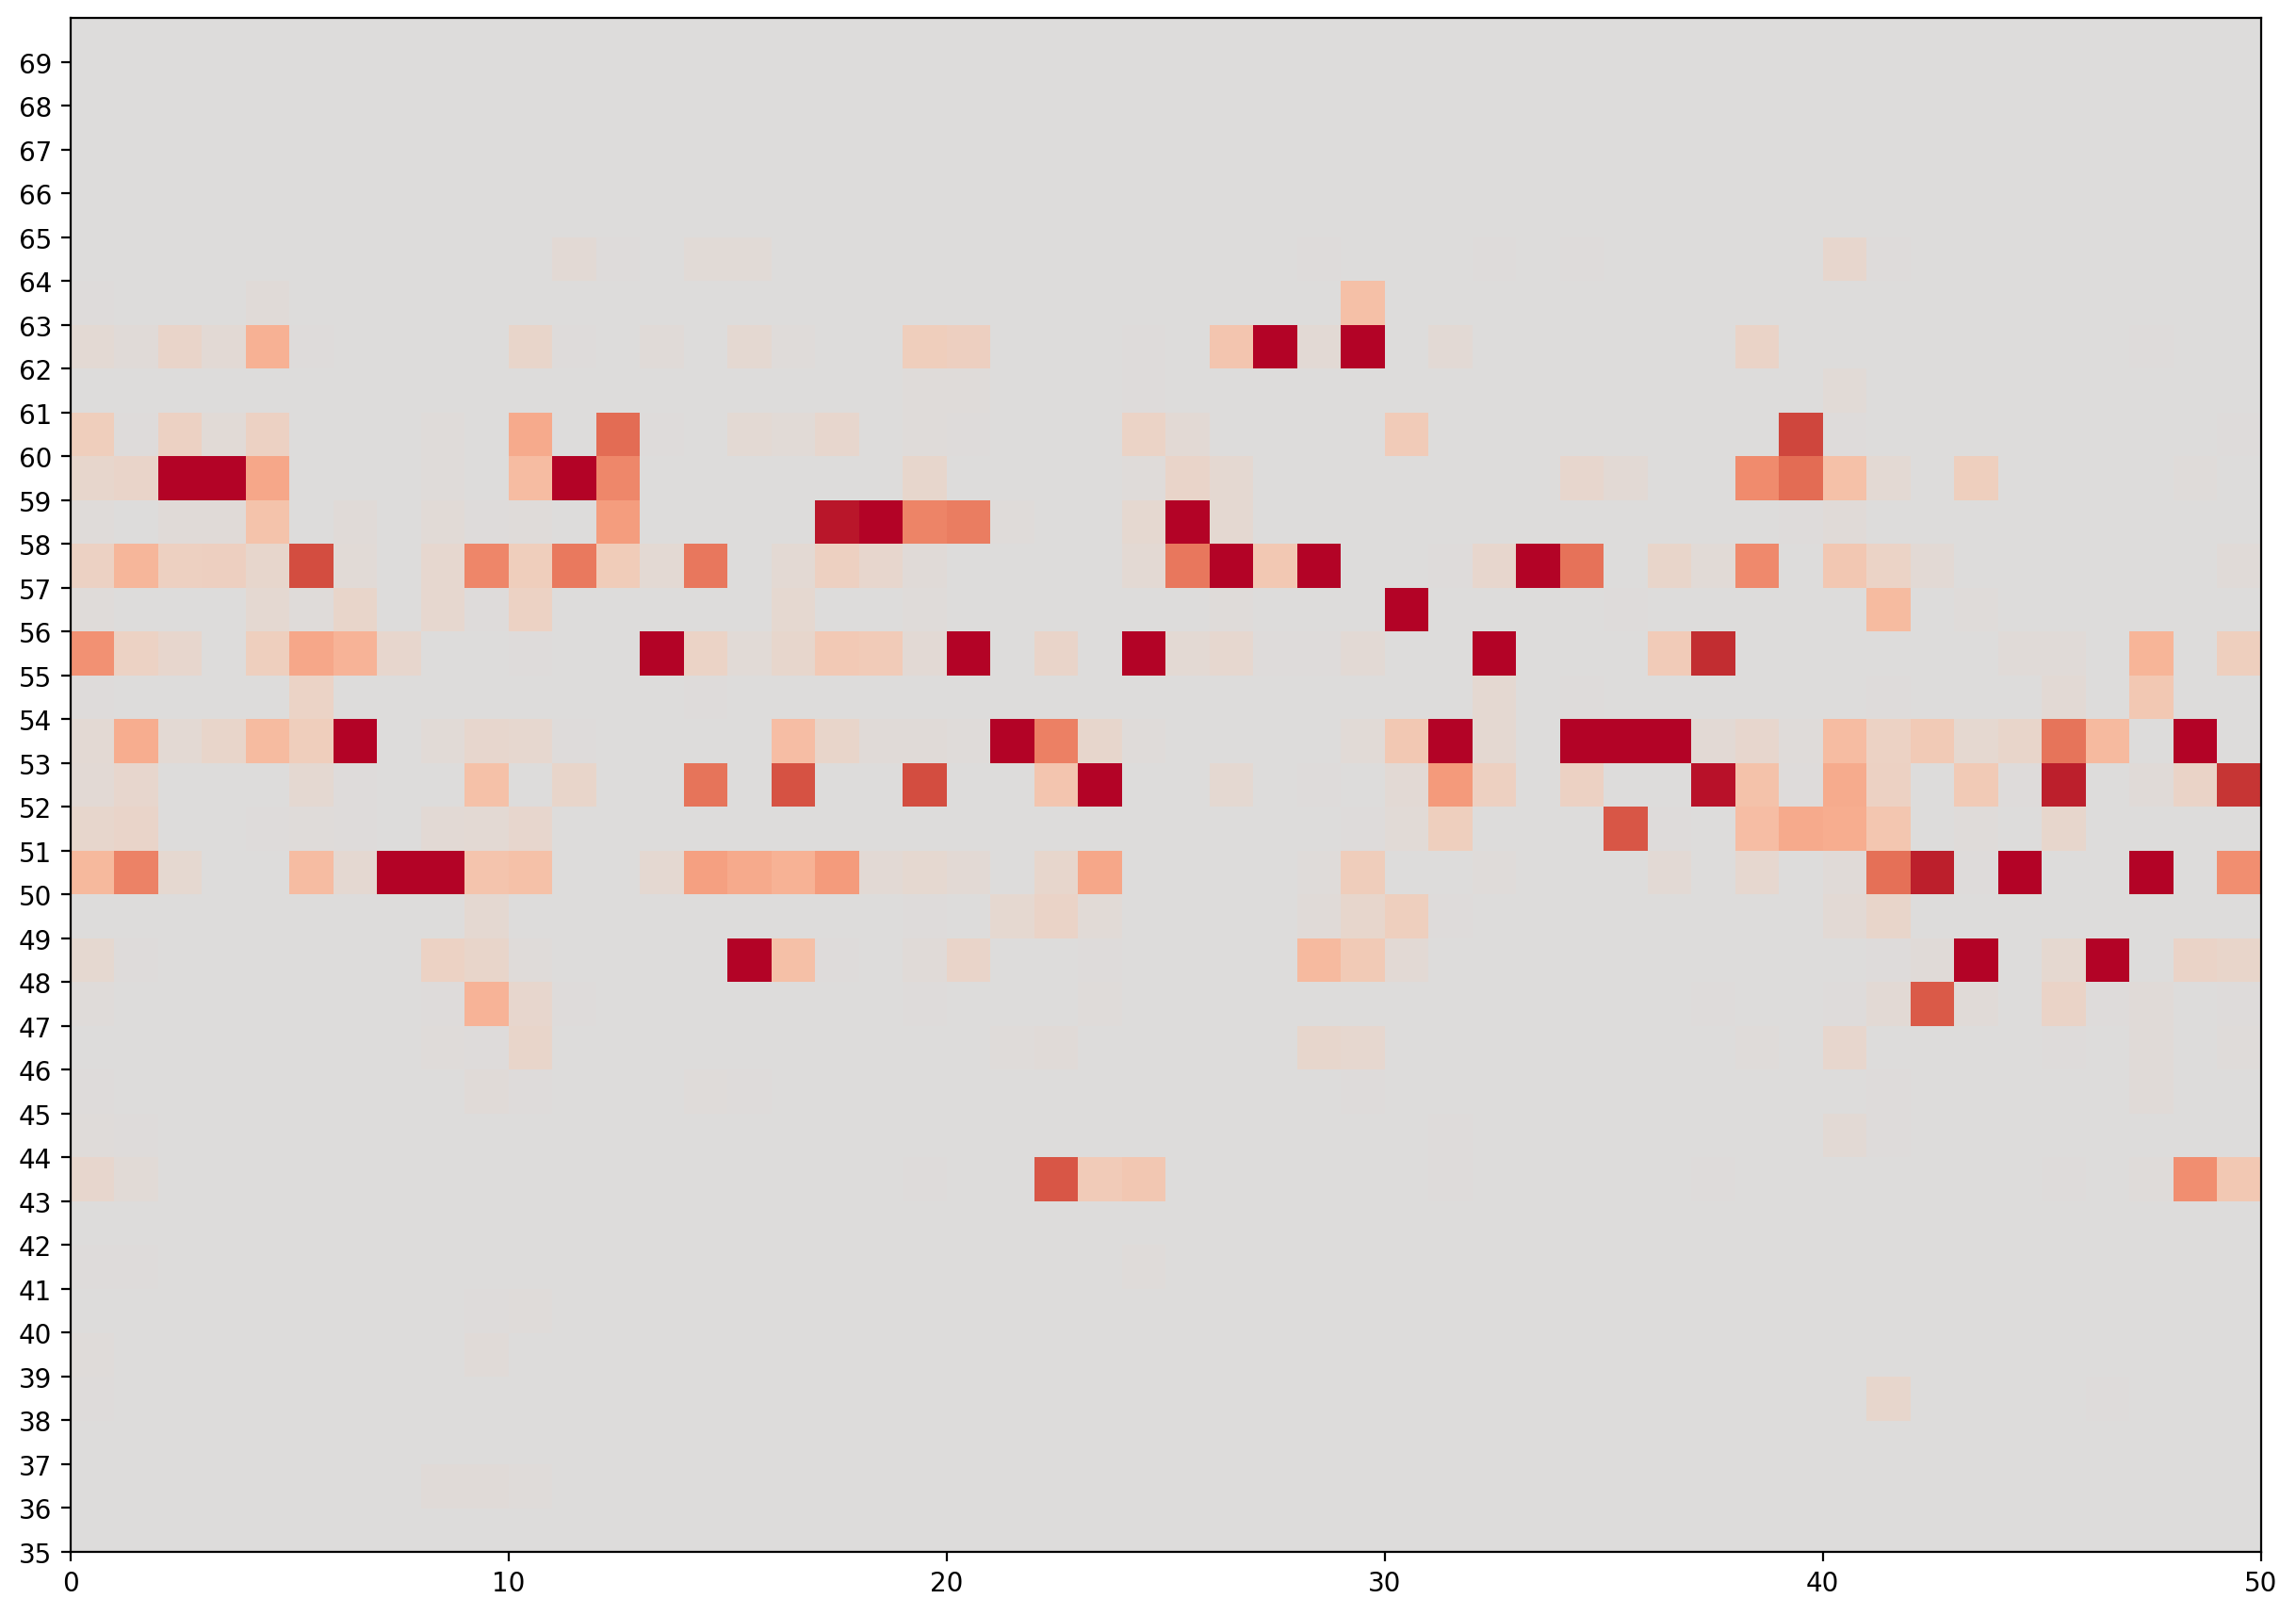

In [109]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_yticks([int(j) for j in range(35,70)])

plt.imshow(overall_preds[35:70,:], origin="lower", cmap='coolwarm', vmin = -0.5, vmax = 0.5, extent=[0, max_extra_notes, 35,70]
          
          )

In [110]:
output_folder = os.path.join(run_folder, 'output')

midi_stream = stream.Stream()

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    note_pattern, duration_pattern = pattern
    # pattern is a chord
    if ('.' in note_pattern):
        notes_in_chord = note_pattern.split('.')
        chord_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(current_note)
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Violoncello()
            chord_notes.append(new_note)
        new_chord = chord.Chord(chord_notes)
        midi_stream.append(new_chord)
    elif note_pattern == 'rest':
    # pattern is a rest
        new_note = note.Rest()
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)
    elif note_pattern != 'START':
    # pattern is a note
        new_note = note.Note(note_pattern)
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)



midi_stream = midi_stream.chordify()
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write('midi', fp=os.path.join(output_folder, 'output-' + timestr + '.mid'))

'run/compose/0006_cello\\output\\output-20230524-044513.mid'

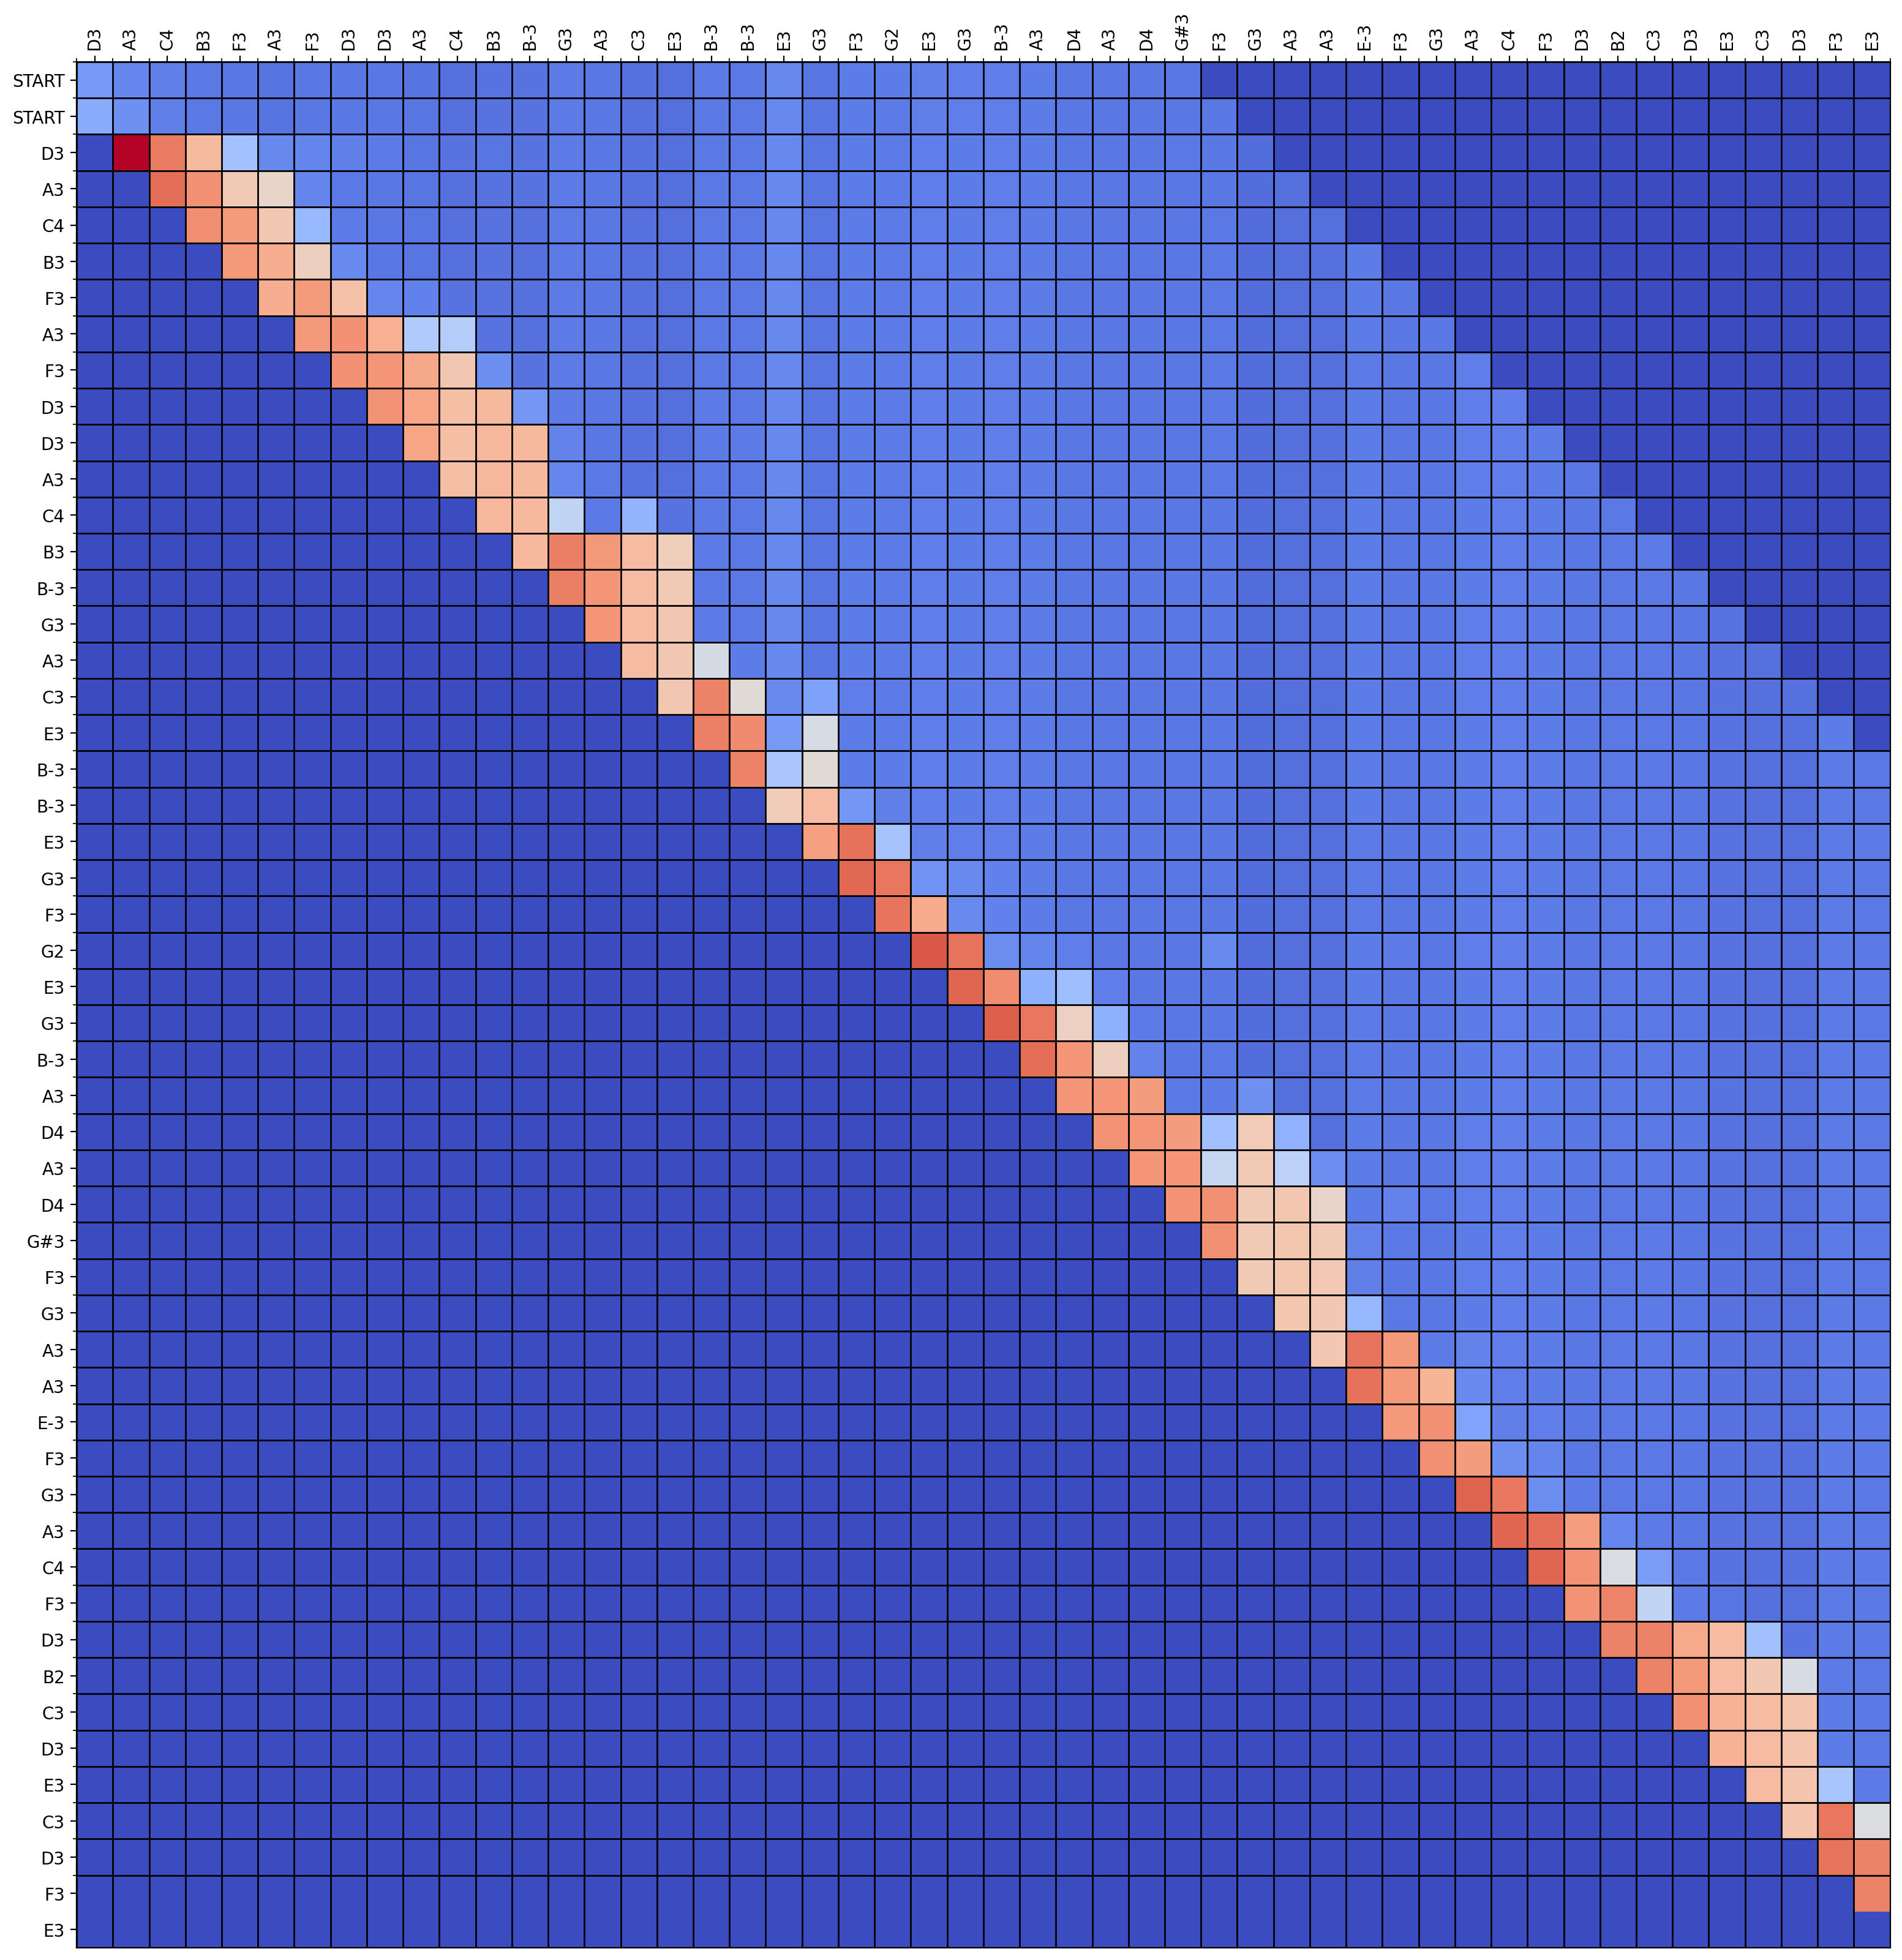

In [111]:
## attention plot
if use_attention:
    fig, ax = plt.subplots(figsize=(20,20))

    im = ax.imshow(att_matrix[(seq_len-2):,], cmap='coolwarm', interpolation='nearest')


    

    # Minor ticks
    ax.set_xticks(np.arange(-.5, len(prediction_output)- seq_len, 1), minor=True);
    ax.set_yticks(np.arange(-.5, len(prediction_output)- seq_len, 1), minor=True);

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    
    
    
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(prediction_output) - seq_len))
    ax.set_yticks(np.arange(len(prediction_output)- seq_len+2))
    # ... and label them with the respective list entries
    ax.set_xticklabels([n[0] for n in prediction_output[(seq_len):]])
    ax.set_yticklabels([n[0] for n in prediction_output[(seq_len - 2):]])

    # ax.grid(color='black', linestyle='-', linewidth=1)

    ax.xaxis.tick_top()


    
    plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va = "center",
             rotation_mode="anchor")

    plt.show()